In [1]:
# Building Non-Linear Models, Part 1
#
# Anuar Konkashbaev
# School of Technology & Engineering, National University
# Course code: 7057984436
# Professor: Dr. Yavarimanesh
# December 4th, 2024
#
# Question 8 from page 286 of the "An Introduction to Statistical Learning: with Applications in Python
# (Springer Texts in Statistics)" book
# by James G., Witten D., Hastie T., Tibshirani R., T. J. 2023.
#

In [22]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.api import graphics

In [2]:
# Function definitions
# Mallow's Cp
def mallowsCp(y_true,y_pred,degFree):
    # y_true is true values for Y
    # y_pred is predicted values for Y
    # degFree is degrees of fredom
    # nvar is number of variables
    #
    return (np.sum((y_true-y_pred)**2)+2*degFree*np.var(y_pred))/len(y_true)
# Getting model parameters and pvalues
def get_coef_table(res,iExclude=False):
    # res is result of model.fit()
    # returns table with coefficient names and corresponding P-values
    # excludes intercept if iExclude set to True, default is False
    coef_table=pd.DataFrame({"name":res.params.index,
                             "coef":res.params.values,
                             "pval":res.pvalues,
                             "rsqr":res.rsquared,
                             },index=res.params.index)
    if(iExclude):
        return coef_table.drop(["Intercept"],axis="index")
    else:
        return coef_table

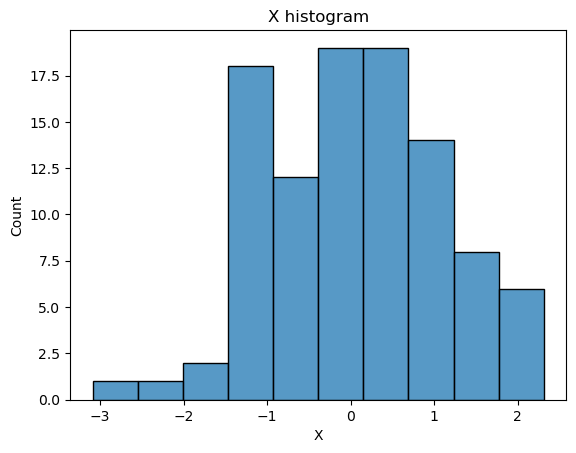

In [183]:
# Generating X vector
X=np.random.normal(size=100)
# Visualizing X distribution 
pl=sns.histplot(X,bins=10)
pl.set_xlabel("X")
pl.set_title("X histogram")
plt.show()

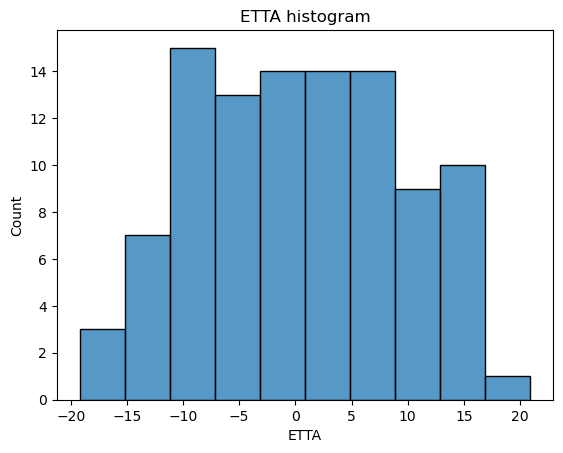

In [184]:
# Generatin errors
etta=np.random.normal(size=100,scale=10)
# Visualizing errors
pl=sns.histplot(etta,bins=10)
pl.set_xlabel("ETTA")
pl.set_title("ETTA histogram")
plt.show()

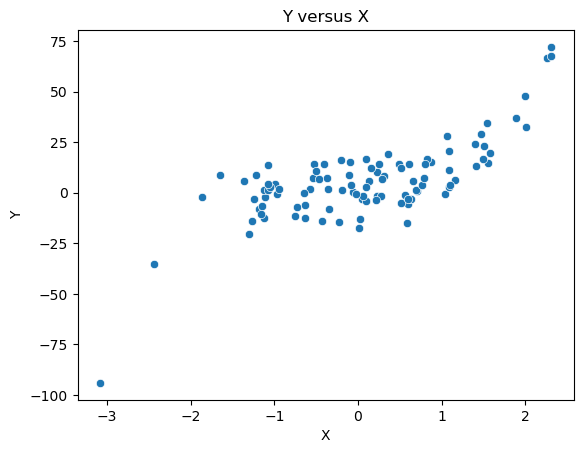

In [185]:
# Generating Y from X and ETTA
Y=1+2*X+3*np.power(X,2)+4*np.power(X,3)+etta
pl=sns.scatterplot(x=X,y=Y)
pl.set_xlabel("X")
pl.set_ylabel("Y")
pl.set_title("Y versus X")
plt.show()

In [186]:
# Forward stepwise method for 1+2*X+3*X**2+4*X**3+etta

In [187]:
# Creating a pandas dataframe out of the generated data
df=pd.DataFrame({"ET":etta})
for i in range(0,10):
    df["X"+str(i+1)]=np.power(X,i+1)
df["Y"]=Y

In [188]:
df.describe()

,ET,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
count,100.000000,100.000000,100.000000,100.000000,1.000000e+02,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,0.542413,0.081540,1.116683,0.162338,3.613647e+00,-0.843496,1.899350e+01,-1.836560e+01,1.293860e+02,-2.186232e+02,1.016131e+03,5.704894
std,9.169564,1.058889,1.546148,4.377070,1.083986e+01,32.026175,9.153274e+01,2.787669e+02,8.361093e+02,2.573503e+03,7.853337e+03,19.657959
min,-19.212043,-3.085118,0.000302,-29.364020,9.092475e-08,-279.485431,2.741721e-11,-2.660130e+03,8.267310e-15,-2.531900e+04,2.492903e-18,-94.027460
25%,-6.891906,-0.638793,0.124857,-0.260693,1.560240e-02,-0.106405,1.951308e-03,-4.343675e-02,2.442315e-04,-1.773452e-02,3.059183e-05,-3.011025
50%,0.644654,0.091850,0.517445,0.000775,2.679084e-01,0.000007,1.387923e-01,5.517190e-08,7.194503e-02,4.655834e-10,3.731569e-02,4.025186
75%,7.520133,0.768457,1.339615,0.454185,1.794568e+00,0.268758,2.404030e+00,1.592295e-01,3.220475e+00,9.445723e-02,4.314197e+00,14.113899
max,20.931323,2.309542,9.517955,12.319053,9.059148e+01,65.709607,8.622456e+02,3.504939e+02,8.206816e+03,1.869528e+03,7.811211e+04,72.073430


In [3]:
# df.to_csv("qubicDataset.csv")
cnames=["ET"]
for i in range(1,11):
    cnames.append("X"+str(i))
cnames.append("Y")
df=pd.read_csv("qubicDataset.csv",usecols=cnames)

In [43]:
dfCorr=df[cnames[1:12]].corr()
dfCorr

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
X1,1.000000,0.043980,0.784662,-0.100159,0.567785,-0.207541,0.447876,-0.261466,0.383259,-0.285494,0.719041
X2,0.043980,1.000000,-0.152954,0.901508,-0.355425,0.772093,-0.464290,0.681070,-0.513650,0.625615,0.091779
X3,0.784662,-0.152954,1.000000,-0.403476,0.933304,-0.558964,0.843649,-0.631645,0.779313,-0.662478,0.860745
X4,-0.100159,0.901508,-0.403476,1.000000,-0.627241,0.964587,-0.735782,0.912510,-0.781742,0.873294,-0.160895
X5,0.567785,-0.355425,0.933304,-0.627241,1.000000,-0.775808,0.977503,-0.840096,0.944746,-0.865532,0.768302
X6,-0.207541,0.772093,-0.558964,0.964587,-0.775808,1.000000,-0.872127,0.987430,-0.910017,0.968917,-0.338635
X7,0.447876,-0.464290,0.843649,-0.735782,0.977503,-0.872127,1.000000,-0.927397,0.992369,-0.947873,0.671468
X8,-0.261466,0.681070,-0.631645,0.912510,-0.840096,0.987430,-0.927397,1.000000,-0.959883,0.995758,-0.430216
X9,0.383259,-0.513650,0.779313,-0.781742,0.944746,-0.910017,0.992369,-0.959883,1.000000,-0.977562,0.606002
X10,-0.285494,0.625615,-0.662478,0.873294,-0.865532,0.968917,-0.947873,0.995758,-0.977562,1.000000,-0.473690


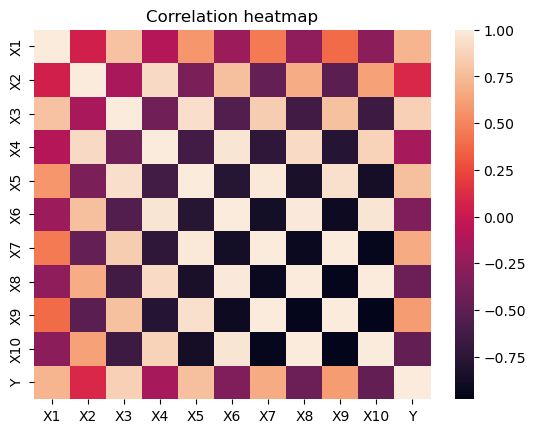

In [44]:
pl=sns.heatmap(dfCorr,annot=False)
plt.title("Correlation heatmap")
plt.show()

In [5]:
# Splitting into training, validation and test datasets
# Even though that ris no paramiter turning for linear regression, I will still need a validation dataset for the Lasso model.
# Sizes of train, test and validation datasets are 0.64,0.2 and 0.14 correspondently
rnd=np.random.randint(123)
df_tv,df_test=train_test_split(df,test_size=0.2,random_state=rnd)
df_train,df_val=train_test_split(df_tv,train_size=0.8,random_state=rnd)

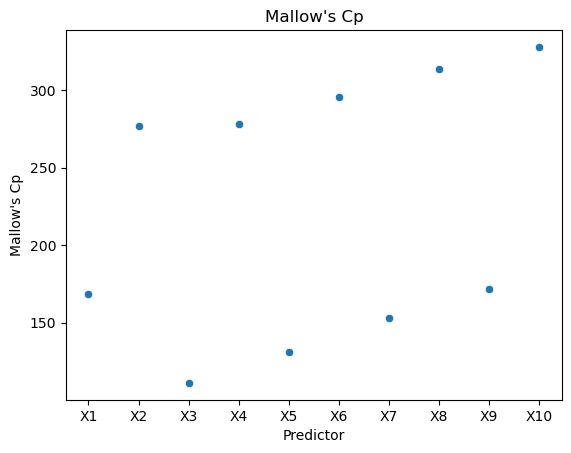

Minimal Mallow's Cp is  111.18041406902073
['X3', 'X5', 'X7', 'X1', 'X9', 'X2', 'X4', 'X6', 'X8', 'X10']


In [122]:
# Creating vector of Xi in decending order by Cp
mCpXi=pd.DataFrame({"X":df_train.columns[1:11],"Cp":np.zeros(10)})
for i in range(1,11):
    cname="X"+str(i)
#     print(cname+":"+str(len(df_train[cname])))
    formula="Y~"+cname
    #mdl=ols(formula,data=df_train)
    mdl=ols(formula,data=sm.add_constant(df_train))
    rmdl=mdl.fit()
    Y_pred=rmdl.predict(df_train)
    mCpXi.loc[i-1,"Cp"]=mallowsCp(df_train["Y"],Y_pred,1)
# Visualize mCpXi
pl=sns.scatterplot(x=mCpXi["X"],y=mCpXi["Cp"])
pl.set_xlabel("Predictor")
pl.set_ylabel("Mallow's Cp")
plt.title("Mallow's Cp")
plt.show()
print("Minimal Mallow's Cp is ",mCpXi["Cp"].min())
# Get the order of predictors by Cp
X_predictors=mCpXi.sort_values(by="Cp")["X"].to_list()
print(X_predictors)

In [20]:
# Since X-cube is the main contributor to the Y values, X3 predictor is has best Mallow's Cp statistic and is the first in the order of predictors.

168.27140367180758  -  Y~X1
136.00180914081432  -  Y~X1+X2
107.0718105951027  -  Y~X1+X2+X3
115.7785063187625  -  Y~X1+X2+X3+X4
122.35610665644151  -  Y~X1+X2+X3+X4+X5
130.3793419758706  -  Y~X1+X2+X3+X4+X5+X6
136.8388970401077  -  Y~X1+X2+X3+X4+X5+X6+X7
145.4850127702926  -  Y~X1+X2+X3+X4+X5+X6+X7+X8
154.39262546552501  -  Y~X1+X2+X3+X4+X5+X6+X7+X8+X9
163.40029376271434  -  Y~X1+X2+X3+X4+X5+X6+X7+X8+X9+X10


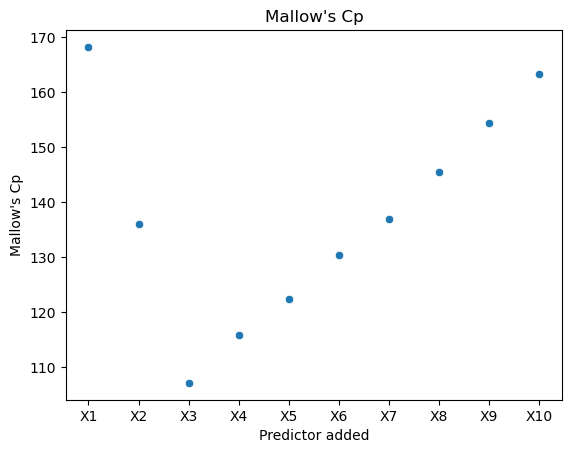

Minimal Mallow's Cp is  107.0718105951027
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     69.99
Date:                Sat, 14 Dec 2024   Prob (F-statistic):           1.41e-19
Time:                        09:54:22   Log-Likelihood:                -231.28
No. Observations:                  64   AIC:                             470.6
Df Residuals:                      60   BIC:                             479.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept 

Intercept    2.697951
X1           2.369942
X2           3.384317
X3           3.263553
dtype: float64

In [163]:
# Forward stepwise method implementation
mCpXi=pd.DataFrame({"cnames":X_predictors,"formula":df_train.columns[1:11],"CpTrain":np.zeros(10),"CpVal":np.zeros(10)})
formula="Y~"
for i in range(10):
    if i==0:
        mCpXi.loc[i,"formula"]=(formula+X_predictors[i]+"+")
    else:
        mCpXi.loc[i,"formula"]=(mCpXi.loc[i-1,"formula"]+X_predictors[i]+"+")
    # print(wformula)
    wformula= mCpXi.loc[i,"formula"][:-1]
    mdl=ols(wformula,data=sm.add_constant(df_train))
    rmdl=mdl.fit()
    Y_pred=rmdl.predict(df_train)
    Y_val=rmdl.predict(df_val)
    mCpXi.loc[i,"CpTrain"]=mallowsCp(df_train["Y"],Y_pred,i+1)
    mCpXi.loc[i,"CpVal"]=mallowsCp(df_val["Y"],Y_val,i+1)
    print(mallowsCp(df_train["Y"],Y_pred,i+1)," - ",wformula)
# Visualize mCpXi
pl=sns.scatterplot(x=mCpXi["cnames"],y=mCpXi["CpTrain"])
pl.set_xlabel("Predictor added")
pl.set_ylabel("Mallow's Cp")
plt.title("Mallow's Cp")
plt.show()
print("Minimal Mallow's Cp is ",mCpXi["CpTrain"].min())
# Get the order of predictors by Cp
formulas=mCpXi.sort_values(by="CpTrain")["formula"].to_list()
mdl=ols(formulas[0][:-1],df_train)
rmdl=mdl.fit()
print(rmdl.summary())
rmdl.params

In [201]:
# From the Mallow's Cp based Forward stepwise method I obtained a model with the only one preddictor.
# Formula is "Y~X3" andd model is Y=3.676132+4.360682*X3
# Ajasted R-squared is - 0.707
# F-statistic is 152.7 with probability 2.24e-18

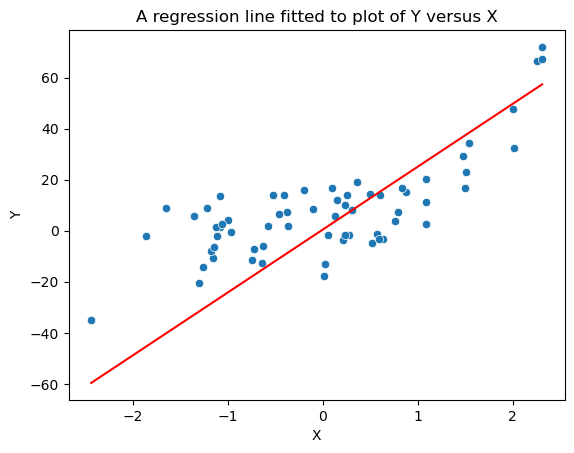

In [110]:
pl=sns.scatterplot(x=df_train["X1"],y=df_train["Y"])
pl.set_xlabel("X")
pl.set_ylabel("Y")
plt.title("A regression line fitted to plot of Y versus X")
x3x=[df_train["X1"].min(),df_train["X1"].max()]
x3y=[3.676132+4.360682*df_train["X3"].min(),3.676132+4.360682*df_train["X3"].max()]
plt.plot(x3x,x3y,color="red")
plt.show()

In [7]:
# Backwards stepwise method.
# Data frame is the same as for the forward stepwize.
#
X_predictors=df_train.columns[1:11]
Xtemp=X_predictors.tolist()
# mCpXi=pd.DataFrame({"cnames":X_predictors,"formula":df_train.columns[1:11],"CpTrain":np.zeros(10),"CpVal":np.zeros(10)})
mCpXi=pd.DataFrame({"cnames":"X","formula":"Y","CpTrain":np.zeros(10),"CpVal":np.zeros(10),"rsqr":0.0})
for i in range(10):
    formula="Y~"+"+".join(Xtemp)
    mdl=ols(formula,sm.add_constant(df_train))
    rmdl=mdl.fit()
    Y_pred=rmdl.predict(df_train)
    Y_val=rmdl.predict(df_val)
    mCpXi.loc[i,"CpTrain"]=mallowsCp(df_train["Y"],Y_pred,10-i)
    mCpXi.loc[i,"CpVal"]=mallowsCp(df_val["Y"],Y_val,10-i)
    mCpXi.loc[i,"formula"]=formula
    mCpXi.loc[1,"rsqr"]=rmdl.rsquared
    cTable=get_coef_table(rmdl,iExclude=True)
    Xexclude=cTable.sort_values(by=["pval"],ascending=False).index[0]
    mCpXi.loc[i,"cnames"]=Xexclude
    print("Index - ","Xp - ","P-Value - ","R-suared - ","Mallow's Cp - ","formula")
    print(i,"-",Xexclude,"-",cTable.loc[Xexclude,"pval"],"-",cTable.loc[Xexclude,"rsqr"],"-",mCpXi.loc[i,"CpTrain"],"-",formula)
    Xtemp.remove(Xexclude)

Index -  Xp -  P-Value -  R-suared -  Mallow's Cp -  formula
0 - X1 - 0.9986890391886174 - 0.8638929344244424 - 182.9408527482703 - Y~X1+X2+X3+X4+X5+X6+X7+X8+X9+X10
Index -  Xp -  P-Value -  R-suared -  Mallow's Cp -  formula
1 - X2 - 0.9504539188872869 - 0.8638929274260003 - 170.77855032716016 - Y~X2+X3+X4+X5+X6+X7+X8+X9+X10
Index -  Xp -  P-Value -  R-suared -  Mallow's Cp -  formula
2 - X9 - 0.8142826518542536 - 0.8638831049521699 - 158.61956459217316 - Y~X3+X4+X5+X6+X7+X8+X9+X10
Index -  Xp -  P-Value -  R-suared -  Mallow's Cp -  formula
3 - X4 - 0.37054470086163016 - 0.8637452252176363 - 146.50592673723918 - Y~X3+X4+X5+X6+X7+X8+X10
Index -  Xp -  P-Value -  R-suared -  Mallow's Cp -  formula
4 - X5 - 0.045732486019453955 - 0.8617624961761372 - 135.07146097770044 - Y~X3+X5+X6+X7+X8+X10
Index -  Xp -  P-Value -  R-suared -  Mallow's Cp -  formula
5 - X7 - 0.5684871890172478 - 0.8516445001664953 - 126.78519342845779 - Y~X3+X6+X7+X8+X10
Index -  Xp -  P-Value -  R-suared -  Mallow's 

In [ ]:
# The lowest Malllow's Cp(100.563) corresponds to the to the formular "Y~X3+X4".
# It is different from Forward stepwize method, because Forward stepwize method does not test model with X3 and X4.
# Backwards stepwise methodgenerates next formula by adding predictor in order by  individual significance, in this case Mallow's Cp score, while
# Backwards stepwise method does it by removing least significant predictors, where significance is obtained from testing a model in conjunction with other variables.
# Backwards stepwise method is could provide a better result than Forward stepwise by using most significant predictors working together.

In [14]:
# Lasso method
# Scale data
scaler=StandardScaler()
df_train_sc=pd.DataFrame(scaler.fit_transform(df_train))
df_test_sc=pd.DataFrame(scaler.fit_transform(df_test))
df_train_sc.columns=df_train.columns
df_test_sc.columns=df_test.columns
# running Lasso
lasso = Lasso(alpha = 0.5)
lasso.fit(df_train_sc[X_predictors],df_train_sc['Y'])
yPred=lasso.predict(df_test_sc[X_predictors])
# Calculating Mallow's Cp
mCpLasso=mallowsCp(df_test_sc["Y"],yPred,10)
mCpLasso

np.float64(0.9488994394636052)

In [ ]:
# Visualization

In [ ]:
# Discussion

In [18]:
# Sevens power
# Generating response vector for all sets
df['Y7']=1+2*df['X7']+df['ET']
df_train['Y7']=1+2*df_train['X7']+df_train['ET']
df_test['Y7']=1+2*df_test['X7']+df_test['ET']
df_val['Y7']=1+2*df_val['X7']+df_val['ET']

111497.82372867936  -  Y7~X1
267745.9296653801  -  Y7~X1+X2
455135.91022372345  -  Y7~X1+X2+X3
492516.74114727863  -  Y7~X1+X2+X3+X4
526459.2534082618  -  Y7~X1+X2+X3+X4+X5
541934.2065332022  -  Y7~X1+X2+X3+X4+X5+X6
556868.6991911033  -  Y7~X1+X2+X3+X4+X5+X6+X7
571541.861688331  -  Y7~X1+X2+X3+X4+X5+X6+X7+X8
586215.6409241344  -  Y7~X1+X2+X3+X4+X5+X6+X7+X8+X9
600890.281386813  -  Y7~X1+X2+X3+X4+X5+X6+X7+X8+X9+X10


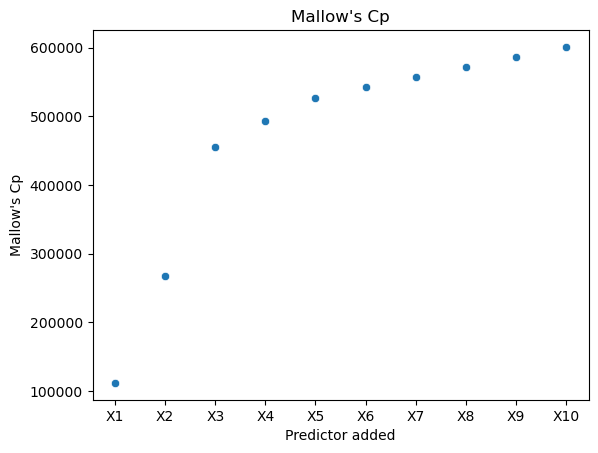

Minimal Mallow's Cp is  111497.82372867936
                            OLS Regression Results                            
Dep. Variable:                     Y7   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     19.72
Date:                Tue, 21 Jan 2025   Prob (F-statistic):           3.77e-05
Time:                        17:37:50   Log-Likelihood:                -499.89
No. Observations:                  64   AIC:                             1004.
Df Residuals:                      62   BIC:                             1008.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept

Intercept    -97.024543
X1           301.905354
dtype: float64

In [19]:
# forward stepwise
mCpXi=pd.DataFrame({"cnames":X_predictors,"formula":df_train.columns[1:11],"CpTrain":np.zeros(10),"CpVal":np.zeros(10)})
formula="Y7~"
for i in range(10):
    if i==0:
        mCpXi.loc[i,"formula"]=(formula+X_predictors[i]+"+")
    else:
        mCpXi.loc[i,"formula"]=(mCpXi.loc[i-1,"formula"]+X_predictors[i]+"+")
    # print(wformula)
    wformula= mCpXi.loc[i,"formula"][:-1]
    mdl=ols(wformula,data=sm.add_constant(df_train))
    rmdl=mdl.fit()
    Y_pred=rmdl.predict(df_train)
    Y_val=rmdl.predict(df_val)
    mCpXi.loc[i,"CpTrain"]=mallowsCp(df_train["Y"],Y_pred,i+1)
    mCpXi.loc[i,"CpVal"]=mallowsCp(df_val["Y"],Y_val,i+1)
    print(mallowsCp(df_train["Y"],Y_pred,i+1)," - ",wformula)
# Visualize mCpXi
pl=sns.scatterplot(x=mCpXi["cnames"],y=mCpXi["CpTrain"])
pl.set_xlabel("Predictor added")
pl.set_ylabel("Mallow's Cp")
plt.title("Mallow's Cp")
plt.show()
print("Minimal Mallow's Cp is ",mCpXi["CpTrain"].min())
# Get the order of predictors by Cp
formulas=mCpXi.sort_values(by="CpTrain")["formula"].to_list()
mdl=ols(formulas[0][:-1],df_train)
rmdl=mdl.fit()
print(rmdl.summary())
rmdl.params

In [20]:
# Discussion

In [21]:
# Lasso for Y7
# Scale data
scaler=StandardScaler()
df_train_sc=pd.DataFrame(scaler.fit_transform(df_train))
df_test_sc=pd.DataFrame(scaler.fit_transform(df_test))
df_train_sc.columns=df_train.columns
df_test_sc.columns=df_test.columns
# running Lasso
lasso7 = Lasso(alpha = 0.5)
lasso7.fit(df_train_sc[X_predictors],df_train_sc['Y7'])
yPred=lasso.predict(df_test_sc[X_predictors])
# Calculating Mallow's Cp
mCpLasso=mallowsCp(df_test_sc["Y7"],yPred,10)
mCpLasso

np.float64(0.6193401575878786)

In [ ]:
# Discussion